# Control strategies for Fokker-Planck equation

The Fokker-Planck equation studied is 
$$
\rho_t = \nabla \cdot (\nu \nabla \rho + \rho \nabla V), x \in \Omega, t \ge 0,
$$
where $J(x,t) = \nu \nabla \rho(x,t) + \rho(x,t) \nabla V(x,t)$ is the probability flux and 
$$
V(x,t) = G(x) + \alpha(x) u(t),
$$
where $G$ is the potential function, $\alpha$ is the control shape function and $u$ is the time-dependent control function.
Moreover, the probability flux is zero in the boundary, that is
$$
(\nu \nabla \rho(x,t) + \rho(x,t) \nabla G(x)) \cdot \vec{n} = 0, \nabla \alpha \cdot \vec{n} = 0, x \in \partial \Omega, t \ge 0.
$$

In [1]:
import numpy as np

from scipy.integrate import quad, solve_ivp, ode, solve_bvp
from scipy.stats import norm, truncnorm, beta
from scipy.linalg import solve_banded, solve_continuous_are
from scipy.special import legendre
from scipy.interpolate import lagrange, interp1d
from scipy.optimize import newton

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class ControlFPequation:
    
    def __init__(self, c_func, parameters) -> None:
        
        self.c = c_func
        
        self.v = parameters['v']
        self.alpha_Q = parameters['alpha_Q']
        self.alpha_Omega = parameters['alpha_Omega']
        self.beta = parameters['beta']
        self.gamma = parameters['gamma']
        self.T = parameters['T']
        self.p0 = parameters['p_0']
        self.pQ = parameters['p_Q']
        self.pOmega = parameters['p_Omega']
        
        self.Lambda = None
        self.B = None
        self.C = None
        self.D = None
        self.E = None
        
    def _calculate_Lambda(self, n_f):
        Lambda = self.v*np.array([[np.sqrt((i+0.5)*(j+0.5))*min(i,j)*(min(i,j)+1)*((i+j)%2==0) for j in range(n_f+1)] 
                                   for i in range(n_f+1)])
        return Lambda
    
    def _calculate_C(self, n_f):
        C = np.zeros((n_f+1, n_f+1))
        for i in range(n_f+1):
            for j in range(n_f+1):
                #C[i,j] = quad(func=lambda x: self.c(x)*self.legendre[j](x)*self.legendre_diff[i](x), a=-1, b=1)[0]
                integrate = np.polyint(legendre(1)*self.legendre[j]*self.legendre_diff[i])
                C[i,j] = 2*(integrate(1.0) - integrate(-1.0))
        return C
    
    def _calculate_B(self, n_f, lim_inf, lim_sup):
        B = np.zeros((n_f+1, n_f+1))
        for i in range(n_f+1):
            for j in range(n_f+1):
                integrate = np.polyint(self.legendre[j]*self.legendre_diff[i])
                B[i,j] = integrate(lim_sup) - integrate(lim_inf)
        return B
    
    def _calculate_D(self, n_f):
        cl = self.c(-1)
        cu = self.c(1) 
        D = np.zeros((n_f-1, n_f+1))
        for k in range(n_f-1):
            M = np.array([
                [np.sqrt(k+1.5)*(self.v*(k+1)*(k+2) - 2*cl), np.sqrt(k+2.5)*(-self.v*(k+2)*(k+3) + 2*cl)],
                [np.sqrt(k+1.5)*(self.v*(k+1)*(k+2) + 2*cu), np.sqrt(k+2.5)*(self.v*(k+2)*(k+3) + 2*cu)],
            ])
            m = np.array([np.sqrt(k+0.5)*(self.v*k*(k+1) - 2*cl), np.sqrt(k+0.5)*(-self.v*k*(k+1) - 2*cu)])
            D[k,k] = 1
            D[k,[k+1,k+2]] = np.linalg.solve(M, m)
        return D
        
    def _calculate_E(self, n_f):
        E = np.zeros((n_f-1, n_f+1))
        for k in range(n_f-1):
            M = np.array([
                [-np.sqrt(k+1.5)*(k+1)*(k+2), np.sqrt(k+2.5)*(k+2)*(k+3)],
                [np.sqrt(k+1.5)*(k+1)*(k+2), np.sqrt(k+2.5)*(k+2)*(k+3)],
            ])
            m = np.array([-np.sqrt(k+0.5)*k*(k+1), -np.sqrt(k+0.5)*k*(k+1)])
            E[k,k] = 1
            E[k,[k+1,k+2]] = np.linalg.solve(M, m)
        return E
    
    def _find_function_coefficients(self, n_f, func):
        coef = np.zeros(n_f+1)
        
        for i in range(n_f+1):
            coef[i] = quad(func=lambda x: func(x)*self.legendre[i](x), a=-1, b=1)[0]
        return coef

After the pre-calculation step, we can define the solving function.

In [3]:
def _solve_ode_equations(self, u_k, n_f, N_t, lim1=None, lim2=None):

    h_t = self.T/N_t
    self.t = np.linspace(0,self.T,N_t+1)

    if self.Lambda is None:
        self.legendre = [(k+0.5)**(0.5)*legendre(k) for k in range(n_f+1)]
        self.legendre_diff = [np.polyder(poly, 1) for poly in self.legendre]
        self.Lambda = self._calculate_Lambda(n_f)
        self.C = self._calculate_C(n_f)
        self.y0 = self._find_function_coefficients(n_f, self.p0)
        self.yQ = self._find_function_coefficients(n_f, self.pQ)
        self.y_omega = self._find_function_coefficients(n_f, self.pOmega)
                
    if self.B is None:
        self.B = self._calculate_B(n_f, lim1, lim2)
        
    u = interp1d(self.t, u_k, fill_value='extrapolate')
        
    # Solve for rho
    rho_vec = np.zeros((n_f+1, N_t+1))
    rho_vec[:,0] = self.y0
    sol = ode(lambda t,y: -(self.Lambda+self.C+u(t)*self.B)@y)
    sol.set_integrator('lsoda')
    sol.set_initial_value(self.y0, 0.0)
    for i in range(1, N_t+1):
        rho_vec[:,i] = sol.integrate(i*h_t)
        
    rho = interp1d(self.t, rho_vec, fill_value='extrapolate')
    
    # Solve for p
    p_vec = np.zeros((n_f+1, N_t+1))
    p_vec[:,0] = self.alpha_Omega*(rho_vec[:,-1] - self.y_omega)
    sol = ode(lambda t,y: -(self.Lambda+self.C.T+u(self.T-t)*self.B.T)@y + self.alpha_Q*(rho(self.T-t) - self.yQ))
    sol.set_integrator('lsoda')
    sol.set_initial_value(p_vec[:,0], 0.0)
    for i in range(1, N_t+1):
        p_vec[:,i] = sol.integrate(i*h_t)
    p_vec = np.flip(p_vec, axis=1) 
    
    return rho_vec, p_vec

def _solve_equation(self, u, n_f, N_t, lim1=None, lim2=None):

    h_t = self.T/N_t
    t = np.linspace(0,self.T,N_t+1)

    self.legendre = [(k+0.5)**(0.5)*legendre(k) for k in range(n_f+1)]
    self.legendre_diff = [np.polyder(poly, 1) for poly in self.legendre]
    Lambda = self._calculate_Lambda(n_f)
    y0 = self._find_function_coefficients(n_f, self.p0)
        
    B = self._calculate_B(n_f, lim1, lim2)
    C = self._calculate_C(n_f)
    D = self._calculate_D(n_f)
                
    # Solve for rho
    rho_vec_ = np.zeros((n_f+1, N_t+1))
    rho_vec_[:,0] = y0
    sol = ode(lambda t,y: -(Lambda+C+u(t)*B)@y)
    sol.set_integrator('lsoda')
    sol.set_initial_value(y0, 0.0)
    for i in range(1, N_t+1):
        rho_vec_[:,i] = sol.integrate(i*h_t)
    rho_vec = np.linalg.solve(D.T[:-2,:], rho_vec_[:-2,:])
    
    phi = [self.legendre[k] + D[k,k+1]*self.legendre[k+1] + D[k,k+2]*self.legendre[k+2] for k in range(n_f-1)]
    rho = lambda x: sum([rho_vec[k, -1]*phi[k](x) for k in range(n_f-1)])
    return rho, rho_vec_

def _calculate_gradient(self, N_t, u_k, rho_k, p_k):
    grad = self.T*(self.gamma * u_k + self.beta - np.array([p_k[:,i]@self.B@rho_k[:,i] for i in range(N_t+1)]))/N_t
    grad[[1,-1]] /= 2 
    #grad = self.gamma * u_k + self.beta - np.array([p_k[:,i]@self.B@rho_k[:,i] for i in range(N_t+1)])
    return grad

ControlFPequation._solve_ode_equations = _solve_ode_equations
ControlFPequation._solve_equation = _solve_equation
ControlFPequation._calculate_gradient = _calculate_gradient

Finally we perform the optimal control finding.

In [68]:
def gradient_descent(self, tol, k_max, u_old, u_new, n_f, N_t, lim1, lim2):
    
    k = 0
    rho_vec, p_vec = self._solve_ode_equations(u_old, n_f, N_t, lim1, lim2)
    gradient_old = self._calculate_gradient(N_t, u_old, rho_vec, p_vec)
    norm_squared = 1.0
    while (norm_squared > tol*tol) and (k < k_max):
        rho_vec, p_vec = self._solve_ode_equations(u_new, n_f, N_t, lim1, lim2)
        gradient_new = self._calculate_gradient(N_t, u_new, rho_vec, p_vec)
        norm_squared = np.dot(gradient_new - gradient_old, gradient_new - gradient_old)
        alpha_k = abs(np.dot(u_new - u_old, gradient_new - gradient_old)/norm_squared)
        u_old, u_new = u_new, u_new - alpha_k * gradient_new
        gradient_old = np.copy(gradient_new)
        k += 1
        print("Done - Iteration {}, ||Grad F(u)||_2^2 = {}  ".format(k, norm_squared), end='\r')
        
    rho_vec, p_vec = self._solve_ode_equations(u_new, n_f, N_t, lim1, lim2)
    return rho_vec, p_vec, u_new

def shooting_method(self, n_f, N_t, lim1=None, lim2=None):

    h_t = self.T/N_t
    self.t = np.linspace(0,self.T,N_t+1)

    if self.Lambda is None:
        self.legendre = [(k+0.5)**(0.5)*legendre(k) for k in range(n_f+1)]
        self.legendre_diff = [np.polyder(poly, 1) for poly in self.legendre]
        self.Lambda = self._calculate_Lambda(n_f)
        self.C = self._calculate_C(n_f)
        self.y0 = self._find_function_coefficients(n_f, self.p0)
        self.yQ = self._find_function_coefficients(n_f, self.pQ)
        self.y_omega = self._find_function_coefficients(n_f, self.pOmega)
        
    if self.B is None:
        self.B = self._calculate_B(n_f, lim1, lim2)
                   
    def fun(t,x):
        derivative = np.zeros_like(x)
        for m in range(x.shape[1]):
            u = (x[n_f+1:, m].T@self.B@x[:n_f+1, m] - self.beta) / self.gamma
            derivative[:n_f+1, m] = -(self.Lambda + self.C + u*self.B)@x[:n_f+1, m]
            derivative[n_f+1:, m] = (self.Lambda + self.C.T + u*self.B.T)@x[n_f+1:, m] - self.alpha_Q*(x[:n_f+1, m] - self.yQ)
        return derivative

    bc = lambda ya, yb: np.hstack([ya[:n_f+1] - self.y0, yb[n_f+1:] - self.alpha_Omega*(yb[:n_f+1] - self.y_omega)])
                
    sol = solve_bvp(fun=fun, bc=bc, x=self.t, y=np.zeros((2*(n_f+1), N_t+1)))
    rho_vec, p_vec = sol.y[:n_f+1, :], sol.y[n_f+1:, :]
    control = np.diag(p_vec.T@self.B@rho_vec - self.beta) / self.gamma
    
    return rho_vec, p_vec, control

def solve_problem(self, tol, k_max, n_f, N_t, u0=None, u1=None, lim1=-0.99, lim2=0.99, method='gradient'):
    
    if method == 'gradient':
        rho_vec, p_vec, control = self.gradient_descent(tol, k_max, u0, u1, n_f, N_t, lim1, lim2)
    elif method == 'shooting':
        rho_vec, p_vec, control = self.shooting_method(n_f, N_t, lim1, lim2)
    
    cost = self.compute_cost(N_t, control, rho_vec)
    
    if self.D is None:
        self.D = self._calculate_D(n_f)
        self.E = self._calculate_E(n_f)
    
    rho_vec = np.linalg.solve(self.D.T[:-2,:], rho_vec[:-2,:])
    p_vec = np.linalg.solve(self.E.T[:-2,:], p_vec[:-2,:])
    
    return cost, rho_vec, p_vec, control
    
def discretise_space_time(self, rho_vec, p_vec, n_f, N_x):
    
    phi_matrix = np.zeros((n_f-1, N_x+1))
    p_matrix = np.zeros((n_f-1, N_x+1))
    x = np.arange(-1.0, 1.0+1.8/N_x, 2/N_x)
    for k in range(n_f-1):
        phi_matrix[k,:] = self.legendre[k](x) + self.D[k,k+1]*self.legendre[k+1](x) + self.D[k,k+2]*self.legendre[k+2](x)
        p_matrix[k,:] = self.legendre[k](x) + self.E[k,k+1]*self.legendre[k+1](x) + self.E[k,k+2]*self.legendre[k+2](x)
    rho = rho_vec.T @ phi_matrix
    p = p_vec.T @ p_matrix
    
    return rho, p

def compute_cost(self, N_t, control, rho_vec):
    cost = 0.5*self.gamma*control[0]**2 + self.beta*control[0] + 0.5*self.alpha_Q*np.sum((rho_vec[:,0] - self.yQ)**2)
    cost += 0.5*self.gamma*control[-1]**2 + self.beta*control[-1] + 0.5*self.alpha_Q*np.sum((rho_vec[:,-1] - self.yQ)**2)
    for i in range(1,N_t):
        cost += self.gamma*control[i]**2 + 2*self.beta*control[i] + self.alpha_Q*np.sum((rho_vec[:,i] - self.yQ)**2)
        cost *= self.T/N_t
        cost += self.alpha_Omega * np.sum((rho_vec[:,-1] - self.y_omega)**2)
    cost *= 0.5
    return cost
        
ControlFPequation.gradient_descent = gradient_descent
ControlFPequation.shooting_method = shooting_method
ControlFPequation.solve_problem = solve_problem
ControlFPequation.compute_cost = compute_cost
ControlFPequation.discretise_space_time = discretise_space_time

## Experiments

First we set the general parameters

In [5]:
N_t = 1000
N_x = 500

c_func = lambda x: 2*x
interval = [-1.0, 1.0]
p_0 = lambda x: 0.5*beta(5,5).pdf(x/2+1/2)
p_Q = lambda x: 0.5*beta(15,5).pdf(x/2+1/2)
parameters = {'v': 0.1, 'T': 10.0, 'p_0': p_0, 'p_Q': p_Q, 'p_Omega': p_Q, 'interval': interval, 
              'gamma': 0.1, 'beta': 0.0, 'alpha_Q': 0.0, 'alpha_Omega': 1.0}

c = 1/quad(lambda x: np.exp(-x**2/parameters['v']), a=-1, b=1)[0]
p_infty = lambda x: c*np.exp(-x**2/parameters['v'])

Calculate the final distribution with a specific control.

In [8]:
%%time
b_func = lambda x: 1*(x > -0.8)*(x < 0.8)
                     
FP_equation = ControlFPequation(b_func, c_func, parameters)

# Calculate the distribution with a specific cntrol function
rho_final, rho_vec_legendre = FP_equation._solve_equation(u=lambda t: np.cos(np.pi*t), n_f=25, N_t=N_t, lim1=-0.8, lim2=0.8)

CPU times: total: 1.64 s
Wall time: 1.99 s


Then, we have the sanity check.

In [9]:
parameters['p_Q'] = rho_final
parameters['p_Omega'] = rho_final
FP_equation = ControlFPequation(b_func, c_func, parameters)

u0 = np.zeros(N_t+1)
u1 = 0.1*np.sin(np.pi*np.linspace(0,10,N_t+1))

cost, rho_vec, p_vec, control = FP_equation.solve_problem(tol=1e-8, k_max=50, n_f=25, N_t=N_t, 
                                                           u0=u0, u1=u1, lim1=-0.8, lim2=0.8,
                                                           method='shooting')
rho, p = FP_equation.discretise_space_time(rho_vec, p_vec, n_f=25, N_x=N_x)

Let's compare the costs

In [10]:
FP_equation.compute_cost(N_t=N_t, control=np.cos(np.pi*FP_equation.t), rho_vec=rho_vec_legendre)

0.0005045373074674806

In [11]:
cost

0.00026875258135357246

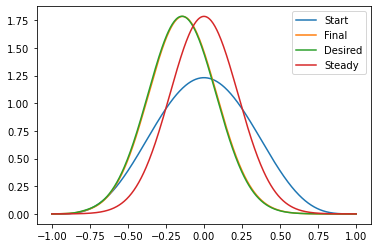

In [12]:
x = np.linspace(-1,1,501)
plt.plot(x, rho[0,:], label='Start')
plt.plot(x, rho[-1,:], label='Final')
plt.plot(x, FP_equation.pOmega(x), label='Desired')
plt.plot(x, p_infty(x), label='Steady')
plt.legend()
plt.show()

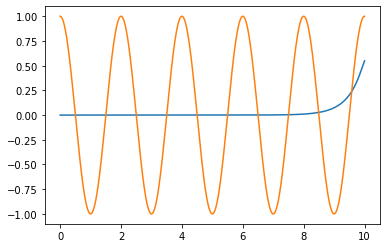

In [13]:
plt.plot(FP_equation.t, control)
plt.plot(FP_equation.t, np.cos(np.pi*FP_equation.t))
plt.show()

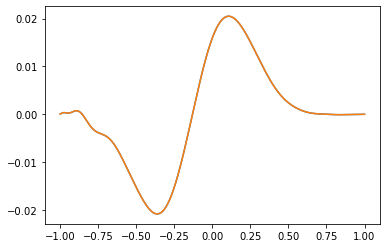

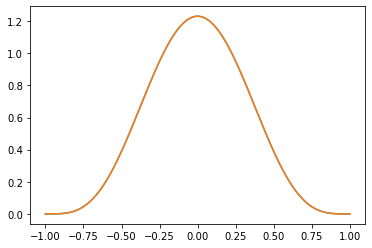

In [14]:
x = np.linspace(-1,1,501)
plt.plot(x, p[-1,:], label='Start')
plt.plot(x, parameters['alpha_Omega']*(rho[-1,:]-FP_equation.pOmega(x)), label='Final')
plt.show()

x = np.linspace(-1,1,501)
plt.plot(x, rho[0,:], label='Start')
plt.plot(x, FP_equation.p0(x), label='Final')
plt.show()

An experiment with the steady state.

In [15]:
parameters['p_Q'] = p_infty
parameters['p_Omega'] = p_infty
FP_equation = ControlFPequation(b_func, c_func, parameters)

u0 = np.zeros(N_t+1)
u1 = 0.1*np.sin(np.pi*np.linspace(0,10,N_t+1))

cost, rho_vec, p_vec, control = FP_equation.solve_problem(tol=1e-8, k_max=50, n_f=25, N_t=N_t, 
                                                           u0=u0, u1=u1, lim1=-0.8, lim2=0.8,
                                                           method='gradient')
rho, p = FP_equation.discretise_space_time(rho_vec, p_vec, n_f=25, N_x=N_x)

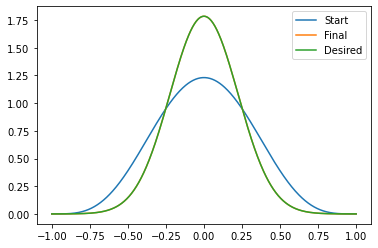

In [16]:
x = np.linspace(-1,1,501)
plt.plot(x, rho[0,:], label='Start')
plt.plot(x, rho[-1,:], label='Final')
plt.plot(x, FP_equation.pOmega(x), label='Desired')
plt.legend()
plt.show()

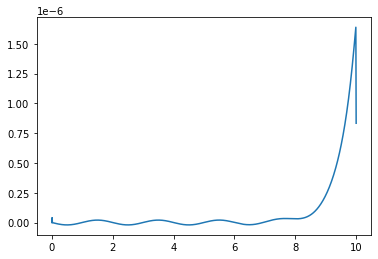

In [17]:
plt.plot(FP_equation.t, control)
plt.show()

Let's see when the final desired distribution has two modes.

In [18]:
parameters['p_Q'] = lambda x: 0.25*beta(15,5).pdf(x/2+1/2) + 0.25*beta(5,15).pdf(x/2+1/2)
parameters['p_Omega'] = lambda x: 0.25*beta(15,5).pdf(x/2+1/2) + 0.25*beta(5,15).pdf(x/2+1/2)
parameters['alpha_Q'] = 1.0
FP_equation = ControlFPequation(b_func, c_func, parameters)

u0 = np.zeros(N_t+1)
u1 = 0.1*np.sin(np.pi*np.linspace(0,10,N_t+1))

cost, rho_vec, p_vec, control = FP_equation.solve_problem(tol=1e-8, k_max=100, n_f=25, N_t=N_t, 
                                                           u0=u0, u1=u1, lim1=-0.8, lim2=0.8,
                                                           method='gradient')
rho, p = FP_equation.discretise_space_time(rho_vec, p_vec, n_f=25, N_x=N_x)

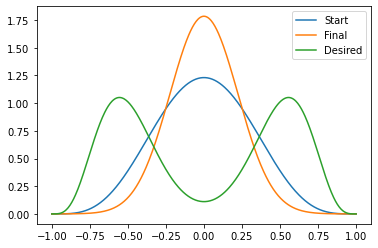

In [19]:
x = np.linspace(-1,1,501)
plt.plot(x, rho[0,:], label='Start')
plt.plot(x, rho[-1,:], label='Final')
plt.plot(x, FP_equation.pOmega(x), label='Desired')
#plt.plot(x, p_infty(x), label='Steady')
plt.legend()
plt.show()

What happens if I impose the control in a non symmetric?

In [20]:
parameters['p_Q'] = lambda x: 0.25*beta(15,5).pdf(x/2+1/2) + 0.25*beta(5,15).pdf(x/2+1/2)
parameters['p_Omega'] = lambda x: 0.25*beta(15,5).pdf(x/2+1/2) + 0.25*beta(5,15).pdf(x/2+1/2)
parameters['alpha_Q'] = 1.0
FP_equation = ControlFPequation(b_func, c_func, parameters)

u0 = np.zeros(N_t+1)
u1 = 0.1*np.sin(np.pi*np.linspace(0,10,N_t+1))

cost, rho_vec, p_vec, control = FP_equation.solve_problem(tol=1e-8, k_max=100, n_f=25, N_t=N_t, 
                                                           u0=u0, u1=u1, lim1=-0.2, lim2=0.8,
                                                           method='gradient')
rho, p = FP_equation.discretise_space_time(rho_vec, p_vec, n_f=25, N_x=N_x)

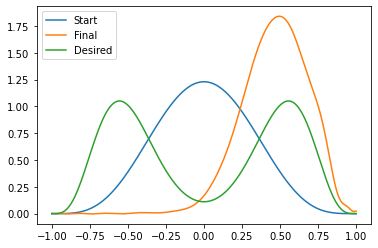

In [21]:
x = np.linspace(-1,1,501)
plt.plot(x, rho[0,:], label='Start')
plt.plot(x, rho[-1,:], label='Final')
plt.plot(x, FP_equation.pOmega(x), label='Desired')
#plt.plot(x, p_infty(x), label='Steady')
plt.legend()
plt.show()

## Searching for actuator

In [7]:
c_func = lambda x: 2*x
interval = [-1.0, 1.0]
p_0 = lambda x: 0.5*beta(5,5).pdf(x/2+1/2)
p_Q = lambda x: 0.5*beta(15,5).pdf(x/2+1/2)
parameters = {'v': 0.1, 'T': 10.0, 'p_0': p_0, 'p_Q': p_Q, 'p_Omega': p_Q, 'interval': interval, 
              'gamma': 0.1, 'beta': 0.0, 'alpha_Q': 0.0, 'alpha_Omega': 1.0}
                     
FP_equation = ControlFPequation(c_func, parameters)

N_t = 1000
N_x = 500

u0 = np.zeros(N_t+1)
u1 = 0.1*np.sin(np.pi*np.linspace(0,10,N_t+1))

cost, rho_vec, p_vec, control = FP_equation.solve_problem(tol=1e-8, k_max=150, n_f=15, N_t=N_t, 
                                                          u0=u0, u1=u1, lim1=-0.9, lim2=0.9,
                                                          method='gradient')
rho, p = FP_equation.discretise_space_time(rho_vec, p_vec, n_f=15, N_x=N_x)

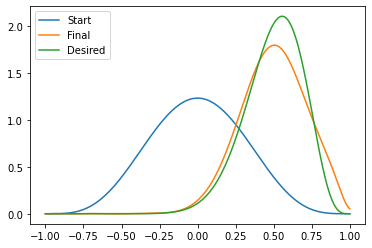

In [8]:
x = np.linspace(-1,1,501)
plt.plot(x, rho[0,:], label='Start')
plt.plot(x, rho[-1,:], label='Final')
plt.plot(x, FP_equation.pOmega(x), label='Desired')
#plt.plot(x, p_infty(x), label='Steady')
plt.legend()
plt.show()

In [69]:
c_func = lambda x: 2*x
interval = [-1.0, 1.0]
p_0 = lambda x: 0.5*beta(5,5).pdf(x/2+1/2)
p_Q = lambda x: 0.5*beta(15,5).pdf(x/2+1/2)
parameters = {'v': 0.1, 'T': 10.0, 'p_0': p_0, 'p_Q': p_Q, 'p_Omega': p_Q, 'interval': interval, 
              'gamma': 0.1, 'beta': 0.0, 'alpha_Q': 1.0, 'alpha_Omega': 1.0}

N_t = 1000
N_x = 500

u0 = np.zeros(N_t+1)
u1 = 0.1*np.sin(np.pi*np.linspace(0,10,N_t+1))

h = 0.25
omega_values = np.linspace(-1+h,1-h, 20)

cost_values = []
rho_values = []
control_values = []

FP_equation = ControlFPequation(c_func, parameters)

for i, omega in tqdm(enumerate(omega_values)):
    FP_equation.B = None
    cost, rho_vec, p_vec, control = FP_equation.solve_problem(tol=1e-7, k_max=150, n_f=20, N_t=N_t, 
                                                              u0=u0, u1=u1, lim1=omega-h/2, lim2=omega+h/2,
                                                              method='gradient')
    cost_values.append(cost)
    rho_values.append(rho_vec)
    control_values.append(control)

0it [00:00, ?it/s]

1it [00:52, 52.50s/it]

2it [01:57, 59.89s/it]

3it [03:04, 63.02s/it]

4it [04:27, 70.85s/it]

5it [06:34, 91.13s/it]

6it [08:36, 101.85s/it]

7it [10:46, 111.02s/it]

8it [13:59, 137.06s/it]

9it [17:04, 151.89s/it]

10it [19:29, 149.89s/it]

11it [21:52, 147.87s/it]

12it [24:27, 149.90s/it]

13it [27:35, 161.60s/it]

14it [30:25, 163.89s/it]

15it [32:03, 144.20s/it]

16it [33:33, 127.91s/it]

17it [35:20, 121.66s/it]

18it [37:04, 116.12s/it]

19it [37:59, 98.03s/it] 

20it [38:54, 116.74s/it]


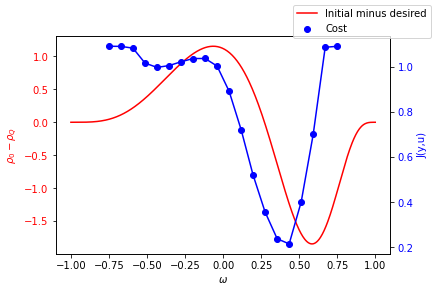

In [72]:
x = np.linspace(-1,1,501)

fig, ax1 = plt.subplots()

color = 'red'
ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$\rho_0 - \rho_Q$', color=color)
ax1.plot(x, p_0(x)-p_Q(x), 
         label='Initial minus desired', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel('J(y,u)', color=color)
ax2.scatter(omega_values, cost_values, label='Cost', color=color)
ax2.plot(omega_values, cost_values, label='', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.legend()
plt.show()